# Experiment 2: Basic RAG

In [1]:
# Setup
import sys
import json
from pathlib import Path
from typing import Dict, List, Any, Optional
from dataclasses import dataclass, asdict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import chromadb
from chromadb.utils import embedding_functions

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

sys.path.append('..')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports loaded")

Imports loaded


In [2]:
# Configuration
DB_PATH = Path("../data/vector_db")
MODEL_PATH = Path("/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it")
OUTPUT_DIR = Path("../evaluation/experiment_02")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

COLLECTION_NAME = "ukrainian_math"
EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

# RAG parameters
TOP_K = 5
TEMPERATURE = 0.7
MAX_NEW_TOKENS = 512

print(f"Database: {DB_PATH}")
print(f"Model: {MODEL_PATH}")
print(f"Top-K: {TOP_K}")
print(f"CUDA: {torch.cuda.is_available()}")

Database: ../data/vector_db
Model: /home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it
Top-K: 5
CUDA: True


In [3]:
@dataclass
class RetrievedChunk:
    text: str
    content_type: str
    confidence: float
    filename: str
    page_start: int
    page_end: int
    distance: float
    relevance: float
    citation: str

@dataclass
class RAGResponse:
    question: str
    answer: str
    citations: List[str]
    retrieved_chunks: List[RetrievedChunk]
    avg_relevance: float
    answer_length: int
    
    def to_dict(self):
        return {
            'question': self.question,
            'answer': self.answer,
            'citations': self.citations,
            'avg_relevance': self.avg_relevance,
            'answer_length': self.answer_length,
            'num_chunks': len(self.retrieved_chunks)
        }

print("Dataclasses defined")

Dataclasses defined


## 1. Load Vector Database

In [4]:
print("="*80)
print("LOADING VECTOR DATABASE")
print("="*80)

client = chromadb.PersistentClient(path=str(DB_PATH))

embedding_function = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBEDDING_MODEL
)

collection = client.get_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_function
)

count = collection.count()
metadata = collection.metadata

print(f"\nVector database loaded")
print(f"  Collection: {COLLECTION_NAME}")
print(f"  Total chunks: {count:,}")
print(f"  Metadata: {metadata}")

LOADING VECTOR DATABASE



Vector database loaded
  Collection: ukrainian_math
  Total chunks: 15,836
  Metadata: {'description': 'Ukrainian mathematics textbooks - AI processed', 'model': 'paraphrase-multilingual-mpnet-base-v2', 'num_chunks': 15836}


## 2. Load LLM

In [5]:
print("="*80)
print("LOADING LLM")
print("="*80)

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
print("Tokenizer loaded")

model = AutoModelForCausalLM.from_pretrained(
    str(MODEL_PATH),
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16
)
print("Model loaded")

if torch.cuda.is_available():
    memory = torch.cuda.memory_allocated() / 1024**3
    print(f"GPU Memory: {memory:.2f} GB")

LOADING LLM


The tokenizer you are loading from '/home/sskaplun/study/genAI/kaggle/models/gemma-2-9b-it' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizer loaded


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded
GPU Memory: 5.71 GB


## 3. RAG Pipeline

In [6]:
SYSTEM_PROMPT = """Ти — досвідчений викладач математики для українських учнів 10-11 класів.

Твоє завдання:
- Згенерувати математичну задачу з розв'язанням на основі ТІЛЬКИ наданого контексту
- Використовувати ТІЛЬКИ українську мову
- Використовувати математичну термінологію з підручників
- Обов'язково посилатися на джерела (наприклад: "За формулою [Джерело 1]...")
- Надати чітке покрокове розв'язання

Формат відповіді:
**Задача:** [текст задачі на основі контексту]

**Розв'язання:**
[покрокове рішення з посиланнями на джерела]

**Відповідь:** [фінальна відповідь]

ВАЖЛИВО: Використовуй ТІЛЬКИ інформацію з наданого контексту!"""

print("System prompt defined")

System prompt defined


In [7]:
def retrieve_chunks(query: str, k: int = TOP_K) -> List[RetrievedChunk]:
    """Retrieve relevant chunks from vector database."""
    results = collection.query(
        query_texts=[query],
        n_results=k
    )
    
    chunks = []
    for doc, meta, dist in zip(
        results['documents'][0],
        results['metadatas'][0],
        results['distances'][0]
    ):
        chunk = RetrievedChunk(
            text=doc,
            content_type=meta['content_type'],
            confidence=meta['confidence'],
            filename=meta['filename'],
            page_start=meta['page_start'],
            page_end=meta['page_end'],
            distance=dist,
            relevance=1 - dist,
            citation=f"[{meta['filename']}, с. {meta['page_start']}-{meta['page_end']}]"
        )
        chunks.append(chunk)
    
    return chunks

print("Retrieval function defined")

Retrieval function defined


In [8]:
def format_context(chunks: List[RetrievedChunk]) -> str:
    """Format chunks into context for LLM."""
    context_parts = []
    
    for i, chunk in enumerate(chunks, 1):
        header = f"[Джерело {i}] {chunk.citation} | Тип: {chunk.content_type}"
        context_parts.append(f"{header}\n{chunk.text}")
    
    return "\n\n".join(context_parts)

print("Context formatter defined")

Context formatter defined


In [9]:
def generate_with_context(
    prompt: str,
    temperature: float = TEMPERATURE,
    max_new_tokens: int = MAX_NEW_TOKENS
) -> str:
    """Generate answer using LLM."""
    messages = [{"role": "user", "content": prompt}]
    formatted = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=0.9,
            do_sample=temperature > 0,
            pad_token_id=tokenizer.eos_token_id
        )
    
    answer = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()
    
    return answer

print("Generation function defined")

Generation function defined


In [10]:
def rag_generate(
    question: str,
    k: int = TOP_K,
    temperature: float = TEMPERATURE,
    verbose: bool = False
) -> RAGResponse:
    """Complete RAG pipeline: retrieve, format, generate."""
    if verbose:
        print(f"Retrieving {k} chunks for: {question}")
    
    chunks = retrieve_chunks(question, k=k)
    
    if verbose:
        avg_rel = np.mean([c.relevance for c in chunks])
        print(f"  Avg relevance: {avg_rel:.3f}")
    
    context = format_context(chunks)
    
    prompt = f"{SYSTEM_PROMPT}\n\nКОНТЕКСТ З ПІДРУЧНИКІВ:\n{context}\n\nЗАПИТАННЯ:\n{question}\n\nТВОЯ ВІДПОВІДЬ:"
    
    if verbose:
        print(f"  Prompt length: {len(prompt)} chars")
        print("  Generating...")
    
    answer = generate_with_context(prompt, temperature=temperature)
    
    if verbose:
        print(f"  Answer: {len(answer)} chars")
    
    return RAGResponse(
        question=question,
        answer=answer,
        citations=[c.citation for c in chunks],
        retrieved_chunks=chunks,
        avg_relevance=float(np.mean([c.relevance for c in chunks])),
        answer_length=len(answer)
    )

print("RAG pipeline defined")

RAG pipeline defined


## 4. Test Questions

In [11]:
from common import STANDARD_TEST_QUESTIONS, EVALUATION_DATASET

TEST_QUESTIONS = STANDARD_TEST_QUESTIONS
print(f"Test set: {len(TEST_QUESTIONS)} questions")

# Create mapping of questions to expected answers
question_to_expected = {q['input']: q['expected_answer'] for q in EVALUATION_DATASET}
print(f"Expected answers loaded for {len(question_to_expected)} questions")

Test set: 15 questions
Expected answers loaded for 10 questions


## 5. Run RAG Experiment

In [12]:
print("="*80)
print("RUNNING BASIC RAG EXPERIMENT")
print("="*80)

responses = []

for i, question in enumerate(TEST_QUESTIONS, 1):
    print(f"\n[{i}/{len(TEST_QUESTIONS)}] {question}")
    print("-"*80)
    
    response = rag_generate(question, verbose=True)
    responses.append(response)
    
    print(f"\nAnswer:\n{response.answer}")
    print(f"\nCitations: {len(response.citations)}")
    for j, citation in enumerate(response.citations[:3], 1):
        print(f"  {j}. {citation}")

print(f"\n{'='*80}")
print(f"Generated {len(responses)} RAG responses")
print("="*80)

RUNNING BASIC RAG EXPERIMENT

[1/15] Квадратні рівняння
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Квадратні рівняння
  Avg relevance: 0.785
  Prompt length: 9471 chars
  Generating...


  Answer: 1068 chars

Answer:
**Задача:**  Знайдіть два числа, якщо їх сума дорівнює 20, а сума їх квадратів – 208.

**Розв'язання:**

1. **Введемо змінні:**
   - Нехай перше число називається *x*.
   - Друге число буде *y*.

2. **Сформуємо систему рівнянь:**
   -  x + y = 20  (сума чисел дорівнює 20)
   -  x² + y² = 208 (сума квадратів чисел дорівнює 208)

3. **Розв'яжемо систему рівнянь:**
   - З першого рівняння виразимо *y*: 
     y = 20 - x
   - Підставимо це значення *y* в друге рівняння:
     x² + (20 - x)² = 208
   - Розкриємо квадрат і спростимо рівняння:
     x² + 400 - 40x + x² = 208
     2x² - 40x + 192 = 0
   - Ділимо рівняння на 2:
     x² - 20x + 96 = 0
   - Знайдемо коріння цього рівняння (використовуючи формулу для розв'язання квадратного рівняння):
     x = (20 ± √(20² - 4 * 1 * 96)) / (2 * 1)
     x = (20 ± √(400 - 384)) / 2
     x = (20 ± √16) / 2
     x = (20 ± 4) / 2
     x₁ = 12,  x₂ = 8
   - Підставимо знайдені значення *x* в рівняння y = 20 - x, щоб знайти відп

  Answer: 531 chars

Answer:
## **Задача:**  

Два брати знайшли на полі 100 яблук. Старший брат сказав, що він знайшов вдвічі більше яблук, ніж молодший. Скільки яблук знайшов кожен з братів?

## **Розв'язання:**

1. **Нехай x - кількість яблук, знайдених молодшим братом.**
2. **Тоді старший брат знайшов 2x яблук.**
3. **Разом вони знайшли x + 2x = 3x яблук.**
4. **Ми знаємо, що 3x = 100.**
5. **Розв'язуємо рівняння: x = 100 / 3 = 33,33 (приблизно).**

**Відповідь:**
* Молодший брат знайшов приблизно 33 яблука.
* Старший брат знайшов приблизно 66 яблук.

Citations: 5
  1. [ister-algeb-p-9ukr-054-13-s.pdf, с. 126-126]
  2. [09-algebra-pidruchnyky-i-posibnyky.pdf, с. 136-136]
  3. [Мерзляк_Якір_Алгебра_7кл..pdf, с. 351-352]

[3/15] Квадратні рівняння
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Квадратні рівняння
  Avg relevance: 0.785
  Prompt length: 9471 chars
  Generating...


  Answer: 1190 chars

Answer:
**Задача:**  Площа прямокутника дорівнює 30, а його периметр – 26. Знайти сторони прямокутника.

**Розв'язання:**
1. **Нехай:**
    *  x - довжина одного боку прямокутника
    *  y - ширина прямокутника

2. **Запишемо відомі дані у вигляді системи рівнянь:**
    *  xy = 30 (площа прямокутника)
    *  2x + 2y = 26 (периметр прямокутника)

3. **Розв'яжемо систему рівнянь:**
    *  З другого рівняння виразимо одну з змінних, наприклад, y: 
       y = 13 - x
    *  Підставимо значення y в перше рівняння: 
       x(13 - x) = 30
    *  Розкриємо дужки і отримаємо квадратне рівняння:
       13x - x2 = 30
    *  Перепишемо рівняння у стандартному вигляді:
       x2 - 13x + 30 = 0
    *  Знайдемо коріння рівняння. Можна використовувати формулу для розв'язання квадратних рівнянь:
       x = (-b ± √(b² - 4ac)) / 2a
       де a = 1, b = -13, c = 30
    *  Підставляємо значення і обчислюємо:
       x = (13 ± √((-13)² - 4 * 1 * 30)) / (2 * 1)
       x = (13 ± √(169 - 12

  Answer: 442 chars

Answer:
## Задача: 

У прямокутному трикутнику ABC з прямим кутом при вершині C, довжина катета AC дорівнює 6 см, а гіпотенузи AB дорівнює 10 см. Знайдіть довжину іншого катета BC.

## Розв'язання:

За теоремою Піфагора, у прямокутному трикутнику квадрат гіпотенузи дорівнює сумі квадратів катетів.

Тоді:

AB² = AC² + BC²

10² = 6² + BC²

100 = 36 + BC²

BC² = 100 - 36

BC² = 64

BC = √64

BC = 8 см

## Відповідь:

Довжина катета BC дорівнює 8 см.

Citations: 5
  1. [matematyka-10kl-nelin-ranok.pdf, с. 191-191]
  2. [orion-9-geometry.pdf, с. 197-198]
  3. [gymnasia-merzlyak-geometry-9-klas.pdf, с. 16-16]

[5/15] Теорема Піфагора
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Теорема Піфагора
  Avg relevance: 0.731
  Prompt length: 10258 chars
  Generating...


  Answer: 466 chars

Answer:
**Задача:**  На рисунку показано прямокутний трикутник ABC, де катет AB = 12 см, а катет BC = 5 см. Знайти гіпотенузу AC.


**Розв'язання:**
За теоремою Піфагора для прямокутного трикутника, квадрат гіпотенузи дорівнює сумі квадратів катетів.

* AC² = AB² + BC²

Підставляємо значення AB і BC:

* AC² = 12² + 5² 
* AC² = 144 + 25
* AC² = 169

Знаходимо корені з обох частин рівняння:

* AC = √169
* AC = 13 см

**Відповідь:** Гіпотенуза AC трикутника дорівнює 13 см.

Citations: 5
  1. [matematyka-10kl-nelin-ranok.pdf, с. 191-191]
  2. [orion-9-geometry.pdf, с. 197-198]
  3. [gymnasia-merzlyak-geometry-9-klas.pdf, с. 16-16]

[6/15] Теорема Піфагора
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Теорема Піфагора
  Avg relevance: 0.731
  Prompt length: 10258 chars
  Generating...


  Answer: 542 chars

Answer:
**Задача:** 

У прямокутному трикутнику ABC, де кут C прямий, сторона AC є катетом, а сторона AB є гіпотенузою.  Знайти довжину сторони BC, якщо AC = 6 см і AB = 10 см.

**Розв'язання:**

За теоремою Піфагора, для прямокутного трикутника a² + b² = c², де a і b - катети, а c - гіпотенуза.

У нашому випадку:

* AC = a = 6 см
* AB = c = 10 см
* BC = b (невідома величина)

Підставляємо значення в формулу теореми Піфагора:

6² + b² = 10²

36 + b² = 100

b² = 100 - 36

b² = 64

b = √64 = 8 см

**Відповідь:**  Довжина сторони BC дорівнює 8 см.

Citations: 5
  1. [matematyka-10kl-nelin-ranok.pdf, с. 191-191]
  2. [orion-9-geometry.pdf, с. 197-198]
  3. [gymnasia-merzlyak-geometry-9-klas.pdf, с. 16-16]

[7/15] Площа трикутника
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Площа трикутника
  Avg relevance: 0.867
  Prompt length: 4364 chars
  Generating...


  Answer: 1333 chars

Answer:
**Задача:**  Рівнобедреному трикутнику з основою 12 см та бічними сторонами 10 см обертається навколо прямої, що проходить через вершину кута при основі перпендикулярно до основи. Знайдіть площу поверхні отриманої поверхні обертання.

**Розв'язання:**

1. **Визначення форми тіла обертання:** Обертання рівнобедреного трикутника навколо прямої, яка проходить через вершину кута при основі перпендикулярно до основи, утворює конус. 

2. **Знаходження радіуса основи конуса:**
    * Основою конуса є коло, радіус якого дорівнює половині основи рівнобедреного трикутника.
    *  *Радіус основи конуса = Основа трикутника / 2 = 12 см / 2 = 6 см*

3. **Знаходження висоти конуса:**
    * Висота конуса дорівнює висоті рівнобедреного трикутника.
    * Застосовуємо теорему Піфагора для знаходження висоти: *Висота² + (Основа / 2)² = Бічна сторона²*
    * *Висота² + 6² = 10²*
    * *Висота² = 100 - 36 = 64*
    * *Висота = √64 = 8 см*

4. **Визначення площі бокової поверхні 

  Answer: 881 chars

Answer:
**Задача:** 

Рівнобедрений трикутник має основу 12 см та бічну сторону 10 см.  Обертаємо цей трикутник навколо прямої, яка проходить через вершину кута при його основі перпендикулярно до основи. Знайдіть площу поверхні отриманої сфери.

**Розв'язання:**

1. **Знайдемо радіус сфери:**

   *  Оскільки трикутник рівнобедрений, його висота є також і медіаною, тобто ділить основу навпіл.
   *  Тому висота трикутника дорівнює √(10² - 6²) = √(100 - 36) = √64 = 8 см.

   *  Ця висота є також і радіусом сфери, оскільки обертання трикутника навколо прямої, яка проходить через вершину кута при його основі перпендикулярно до основи, утворює сферу.

2. **Обчислимо площу сфери:**

   *  Площа поверхні сфери обчислюється за формулою: S = 4πr², де r - радіус сфери. 
   *  S = 4 * π * (8 см)² = 4 * π * 64 см² = 256π см²

**Відповідь:** Площа поверхні отриманої сфери дорівнює 256π см².

Citations: 5
  1. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riv

  Answer: 861 chars

Answer:
**Задача:**  Рівнобедреному трикутнику, основа якого дорівнює 12 см, а бічна сторона — 10 см, обертаємо навколо прямої, яка проходить через вершину кута при його основі перпендикулярно до основи. Знайти площу поверхні отриманої сфери.

**Розв'язання:**

1. **Знайдемо радіус сфери.**

   -  Радіус сфери дорівнює відстані від вершини рівнобедреного трикутника до основи. Ця відстань є висотою трикутника.

   - За теоремою про висоту рівнобедреного трикутника: висота ділить основу на дві рівні частини.

   - Застосовуємо теорему Піфагора, щоб знайти висоту (і радіус сфери):  *h² + (12/2)² = 10²*

   -  *h² + 36 = 100*

   -  *h² = 64*

   -  *h = 8 см*

2. **Знайдемо площу сфери.**

   - Площа сфери обчислюється за формулою: *S = 4πr²*, де *r* — радіус сфери.

   - *S = 4π(8²) = 256π см²*

**Відповідь:** Площа поверхні отриманої сфери дорівнює 256π см².

Citations: 5
  1. [merzlyak-ag-geometriya-pochatok-vyvch-na-poglyb-rivni-z-8-kl-prof-riven-11-kl.pdf, с. 191

  Answer: 1096 chars

Answer:
**Задача:**  У кулю вписано правильну трикутну піраміду, сторона основи якої дорівнює 6 см, а бічне ребро утворює з площиною основи кут 60°. Знайдіть об’єм кулі.

**Розв’язання:**

1. **Знайдемо висоту піраміди:**
   - Нехай *O* - центр кулі, *A*, *B*, *C* - вершини основи піраміди, а *S* - вершина піраміди.
   - Згідно з задачею, кут *OSA* дорівнює 60°.
   - Через те, що піраміда правильна, трикутник *ASO* є рівностороннім, отже, *AS = SO = AO*.
   - Висота піраміди *SO* - це також середня лінія в трикутнику *ASO*.
   - За формулою для висоти рівностороннього трикутника: *SO = (√3/2) * AS = (√3/2) * 6 = 3√3 см*.

2. **Знайдемо радіус кулі:**
   - Радіус кулі дорівнює довжині відрізка *OA*.
   - Трикутник *ASO* - прямокутний, тому за теоремою Піфагора: *OA² = AS² + SO²*.
   - Підставляючи значення: *OA² = 6² + (3√3)² = 36 + 27 = 63*.
   - Отже, *OA = √63 = 3√7 см*.

3. **Обчислимо об'єм кулі:**
   - За формулою об'єму кулі: *V = (4/3)πr³*.
   - Підставляюч

  Answer: 1192 chars

Answer:
**Задача:** 

У кулю вписано правильну трикутну піраміду, сторона основи якої дорівнює 6 см, а бічне ребро утворює з площиною основи кут 60°. Знайдіть об’єм кулі.

**Розв'язання:**

1. **Знайдемо висоту піраміди.**

   -  Висота піраміди є також висотою рівностороннього трикутника, сторони якого дорівнюють бічним ребрам піраміди. 
   -  Використовуючи формулу для знаходження висоти рівностороннього трикутника: h = (a√3)/2, де a - сторона трикутника, отримаємо: h = (6√3)/2 = 3√3 см.

2. **Знайдемо радіус кулі.**

   -  Радіус кулі дорівнює довжині відстані від центру кулі до вершини піраміди. 
   -  Це відстань є гіпотенузою прямокутного трикутника, де катет - висота піраміди, а другий катет - половина висоти піраміди. 
   -  Застосуємо теорему Піфагора: r² = h² + (a/2)², де r - радіус кулі, h - висота піраміди, a - сторона основи піраміди.
   -  Підставляємо значення: r² = (3√3)² + (6/2)² = 27 + 9 = 36.
   -  Отже, r = √36 = 6 см.

3. **Знайдемо об'єм кулі

  Answer: 1112 chars

Answer:
**Задача:** 

У кулі вписано правильну трикутну піраміду, сторона основи якої дорівнює 6 см, а бічне ребро утворює з площиною основи кут 60°. Знайдіть об'єм кулі.

**Розв'язання:**

1. **Знайдемо висоту піраміди:**
   - Нехай H - висота піраміди.
   - У трикутнику, утвореному бічним ребром піраміди, половиною висоти піраміди та половиною сторони основи, кут між бічним ребром та основою дорівнює 60°.
   - Застосуємо функцію cos: cos(60°) = (H/2) / (6/2) = H/6
   - Отже, H = 6 * cos(60°) = 6 * 0.5 = 3 см

2. **Знайдемо площу основи піраміди:**
   - Основа піраміди - рівносторонній трикутник з стороною 6 см.
   - Площа рівностороннього трикутника: S = (√3 / 4) * a² = (√3 / 4) * 6² = 9√3 см²

3. **Знайдемо об'єм піраміди:**
   - Об'єм піраміди: V = (1/3) * S * H = (1/3) * 9√3 * 3 = 9√3 см³

4. **Знайдемо радіус кулі:**
   - Радіус кулі дорівнює радіусу кола, яке є основою піраміди. 
   - Діаметр кола - це сторона основи піраміди (6 см), тому радіус дорівнює 3 

This is a friendly reminder - the current text generation call has exceeded the model's predefined maximum length (8192). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


  Answer: 828 chars

Answer:
## Розв'язання задачі

**Задача:** 
Знайдіть розв'язок нерівності: 
log(x - 1)(x + 5) < 4


**Розв'язання:**

1. **Перетворюємо нерівності:**

   Застосовуємо властивості логарифмів, щоб перетворити нерівності в рівняння.
   
   *  log(x - 1)(x + 5) < 4  => (x - 1)(x + 5) < 10^4
   *   (x - 1)(x + 5) < 10000


2. **Вирішуємо рівняння:**

   *  x^2 + 4x - 6 < 10000
   *  x^2 + 4x - 10006 < 0
   *  Використовуємо формулу для розв'язування квадратного рівняння:

   x = (-b ± √(b^2 - 4ac) / 2a
   де a = 1, b = 4, c = -10006

   *  x = (-4 ± √(4^2 - 4 * 1 * -10006) / (2 * 1)

3. **Знаходимо корені:**

   *   x = (-4 ± √(16 + 40024) / 2
   *   x = (-4 ± √40040) / 2
   *   x = (-4 ± 200.2
   *   x1 = 100 + 200.2 / 2
   *   x1 = 102.1
   *   x2 = -100 - 200.2 / 2
   *   x2 = -102.1


**Відповідь:**

   *   -102.1 < x < 102.1

Citations: 5
  1. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 94-94]
  2. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 32-32]
  3. [ister-algebrap

  Answer: 278 chars

Answer:
## Задача:

**Показникова та логарифмічна функції**


**1.  **

**Розв’язання**

1. **Приклад 3.  **
  
  *  Напишіть показнічну функцію, яка зображає, що 
  *  **Показникова функція**

**2. 1. Îáëàñòü  один з двох способів:**
*  *  **1)  **
*  **2)  **
*  *  **3)  **

**3.  **

Citations: 5
  1. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 94-94]
  2. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 32-32]
  3. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 42-42]

[15/15] Логарифми
--------------------------------------------------------------------------------
Retrieving 5 chunks for: Логарифми
  Avg relevance: 0.703
  Prompt length: 12741 chars
  Generating...


  Answer: 834 chars

Answer:
##  Логарифми

**ВІДПОВІДЬ**

**Що таке логарифм?**

Логарифм – це показник, до якого потрібно підняти певну базу, щоб отримати дане число. 

**Формула:**

log<sub>a</sub>(x) = y  значить, що a<sup>y</sup> = x

**Основні властивості логарифмів:**

* log<sub>a</sub>(1) = 0
* log<sub>a</sub>(a) = 1
* log<sub>a</sub>(x*y) = log<sub>a</sub>(x) + log<sub>a</sub>(y)
* log<sub>a</sub>(x/y) = log<sub>a</sub>(x) - log<sub>a</sub>(y)
* log<sub>a</sub>(x<sup>n</sup>) = n * log<sub>a</sub>(x)

**Приклад:**

log<sub>2</sub>(8) = 3, бо 2<sup>3</sup> = 8

**Типи логарифмів:**

* Десяткові логарифми (log)
* Натуральні логарифми (ln)


**Задача:**

Знайдіть логарифм 100 за основою 10.
 

**Відповідь:**
log<sub>10</sub>(100) = 2

**Використовувані джерела:**

* [https://ru.wikipedia.org/wiki/Логарифм](https://ru.wikipedia.org/wiki/Логарифм)

Citations: 5
  1. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 94-94]
  2. [ister-algebrapr-p-11ukr-081-18-s.pdf, с. 32-32]
  3. [ister-al

## 6. Evaluation

In [13]:
import common

print("Evaluation functions loaded from common.py")

Evaluation functions loaded from common.py


In [14]:
# Evaluate
print("="*80)
print("EVALUATION")
print("="*80)

evaluations = []

for i, response in enumerate(responses, 1):
    # Get expected answer for this question
    expected = question_to_expected.get(response.question, None)
    
    # Evaluate with expected answer for correctness
    metrics = common.evaluate_basic_rag(
        response.answer,
        response.answer_length,
        response.avg_relevance,
        expected_answer=expected
    )
    
    evaluations.append({
        'question': response.question,
        'metrics': metrics,
        'answer_length': response.answer_length,
        'avg_relevance': response.avg_relevance,
        'expected_answer': expected
    })
    
    print(f"\n{i}. {response.question[:50]}...")
    print(f"   Overall: {metrics['overall_score']:.3f} | "
          f"Retrieval: {metrics['retrieval_quality']:.3f} | "
          f"Correctness: {metrics['correctness']:.3f} | "
          f"Ukrainian: {metrics['ukrainian_ratio']:.3f}")

# Summary
print(f"\n{'='*80}")
print("SUMMARY")
print("="*80)

avg_metrics = {
    'overall_score': np.mean([e['metrics']['overall_score'] for e in evaluations]),
    'retrieval_quality': np.mean([e['metrics']['retrieval_quality'] for e in evaluations]),
    'ukrainian_ratio': np.mean([e['metrics']['ukrainian_ratio'] for e in evaluations]),
    'completeness': np.mean([e['metrics']['completeness'] for e in evaluations]),
    'structure_rate': sum(e['metrics']['has_structure'] for e in evaluations) / len(evaluations),
    'citation_rate': sum(e['metrics']['has_citations'] for e in evaluations) / len(evaluations),
    'correctness': np.mean([e['metrics']['correctness'] for e in evaluations])
}

for key, value in avg_metrics.items():
    print(f"  {key:20s}: {value:.3f}")

EVALUATION

1. Квадратні рівняння...
   Overall: 0.770 | Retrieval: 0.785 | Correctness: 0.000 | Ukrainian: 0.939

2. Квадратні рівняння...
   Overall: 0.930 | Retrieval: 0.785 | Correctness: 1.000 | Ukrainian: 0.979

3. Квадратні рівняння...
   Overall: 0.671 | Retrieval: 0.785 | Correctness: 0.000 | Ukrainian: 0.944

4. Теорема Піфагора...
   Overall: 0.743 | Retrieval: 0.731 | Correctness: 0.000 | Ukrainian: 0.895

5. Теорема Піфагора...
   Overall: 0.744 | Retrieval: 0.731 | Correctness: 0.000 | Ukrainian: 0.897

6. Теорема Піфагора...
   Overall: 0.742 | Retrieval: 0.731 | Correctness: 0.000 | Ukrainian: 0.889

7. Площа трикутника...
   Overall: 0.709 | Retrieval: 0.867 | Correctness: 0.000 | Ukrainian: 0.997

8. Площа трикутника...
   Overall: 0.806 | Retrieval: 0.867 | Correctness: 0.000 | Ukrainian: 0.985

9. Площа трикутника...
   Overall: 0.805 | Retrieval: 0.867 | Correctness: 0.000 | Ukrainian: 0.979

10. Об'єм кулі...
   Overall: 0.645 | Retrieval: 0.713 | Correctness: 0.0

## 7. Visualization

In [15]:
# Create DataFrame
df = pd.DataFrame([
    {
        'question_num': i+1,
        'question': e['question'][:40] + '...',
        'overall': e['metrics']['overall_score'],
        'retrieval': e['metrics']['retrieval_quality'],
        'ukrainian': e['metrics']['ukrainian_ratio'],
        'citations': int(e['metrics']['has_citations']),
        'length': e['answer_length']
    }
    for i, e in enumerate(evaluations)
])

print(df.to_string())

    question_num               question   overall  retrieval  ukrainian  citations  length
0              1  Квадратні рівняння...  0.770254   0.785034   0.938976          0    1068
1              2  Квадратні рівняння...  0.930348   0.785034   0.979351          0     531
2              3  Квадратні рівняння...  0.671414   0.785034   0.943615          0    1190
3              4    Теорема Піфагора...  0.743028   0.730840   0.895105          0     442
4              5    Теорема Піфагора...  0.743504   0.730840   0.897010          0     466
5              6    Теорема Піфагора...  0.741560   0.730840   0.889231          0     542
6              7    Площа трикутника...  0.709246   0.866932   0.996667          0    1333
7              8    Площа трикутника...  0.806342   0.866932   0.985050          1     881
8              9    Площа трикутника...  0.804798   0.866932   0.978873          1     861
9             10          Об'єм кулі...  0.644744   0.713450   0.922835          1    1096

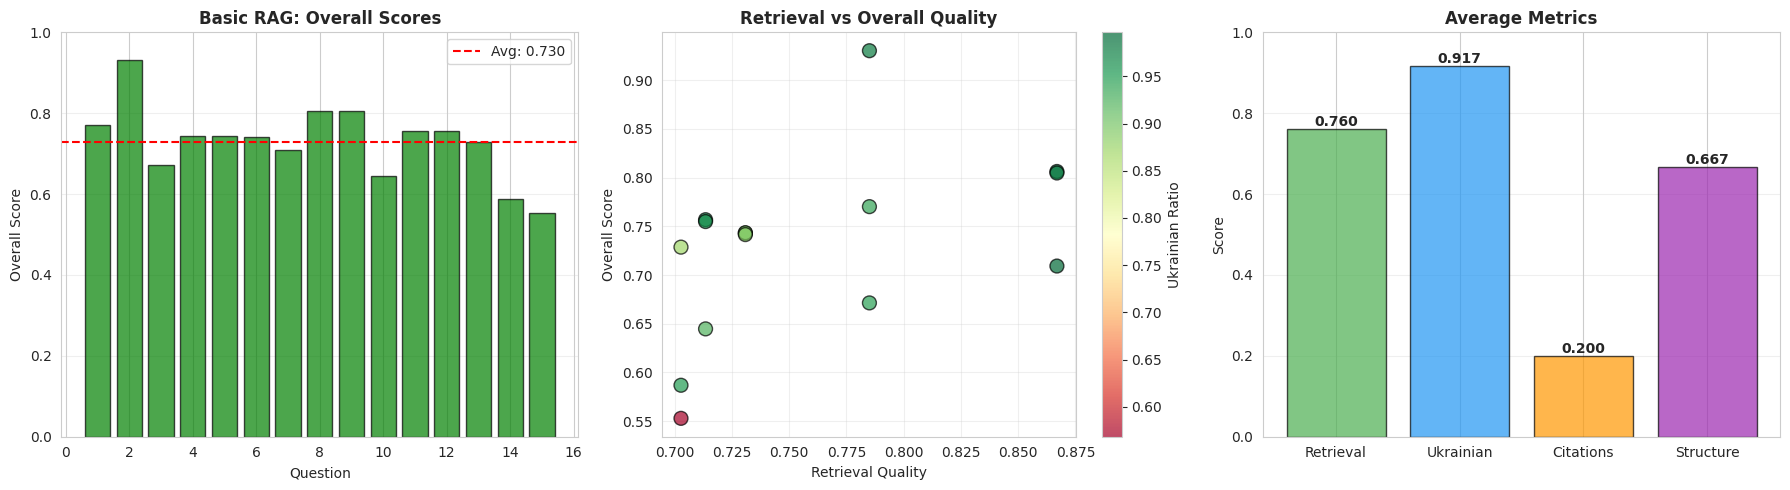

Visualization saved


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
bars = ax.bar(df['question_num'], df['overall'], color='green', alpha=0.7, edgecolor='black')
ax.axhline(y=avg_metrics['overall_score'], color='red', linestyle='--',
           label=f"Avg: {avg_metrics['overall_score']:.3f}")
ax.set_xlabel('Question')
ax.set_ylabel('Overall Score')
ax.set_title('Basic RAG: Overall Scores', fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[1]
scatter = ax.scatter(df['retrieval'], df['overall'], s=100, alpha=0.7, 
                     c=df['ukrainian'], cmap='RdYlGn', edgecolors='black')
ax.set_xlabel('Retrieval Quality')
ax.set_ylabel('Overall Score')
ax.set_title('Retrieval vs Overall Quality', fontweight='bold')
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Ukrainian Ratio')

ax = axes[2]
metrics_data = [
    avg_metrics['retrieval_quality'],
    avg_metrics['ukrainian_ratio'],
    avg_metrics['citation_rate'],
    avg_metrics['structure_rate']
]
labels = ['Retrieval', 'Ukrainian', 'Citations', 'Structure']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']
bars = ax.bar(labels, metrics_data, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Score')
ax.set_title('Average Metrics', fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, metrics_data):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rag_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved")

## 8. Save Results

In [17]:
results = {
    'experiment': 'basic_rag',
    'description': 'Vanilla RAG with semantic search and context injection',
    'model': 'gemma-2-9b-it',
    'embedding_model': EMBEDDING_MODEL,
    'top_k': TOP_K,
    'temperature': TEMPERATURE,
    'avg_metrics': avg_metrics,
    'responses': [r.to_dict() for r in responses],
    'evaluations': evaluations
}

with open(OUTPUT_DIR / 'results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

df.to_csv(OUTPUT_DIR / 'evaluation.csv', index=False)

print(f"Results saved to {OUTPUT_DIR}")
print("\n" + "="*80)
print("EXPERIMENT 2 COMPLETE")
print("="*80)
print(f"\nOverall Score: {avg_metrics['overall_score']:.3f}")
print(f"Retrieval Quality: {avg_metrics['retrieval_quality']:.3f}")
print(f"Correctness: {avg_metrics['correctness']:.3f}")
print(f"Ukrainian Ratio: {avg_metrics['ukrainian_ratio']:.3f}")
print(f"Citation Rate: {avg_metrics['citation_rate']:.3f}")

Results saved to ../evaluation/experiment_02

EXPERIMENT 2 COMPLETE

Overall Score: 0.730
Retrieval Quality: 0.760
Correctness: 0.067
Ukrainian Ratio: 0.917
Citation Rate: 0.200
